In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from pathlib import Path
import os
home = str(Path.home())

import helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## data preparation 

### setup `data_dir`

First of all let's look at our data. We have images of cats and dogs (`11,250` images of each of 2 our classes) and have to classify them. The structure of the folders is below. This structure is required if we use `datasets.ImageFolder`.

In [10]:
data_dir = os.path.join(home, 'data/cat_dog_data')
data_train_dir = os.path.join(data_dir, 'train')

In [11]:
data_dir, data_train_dir

('/Users/ilyarudyak/data/cat_dog_data',
 '/Users/ilyarudyak/data/cat_dog_data/train')

In [15]:
!tree -d /Users/ilyarudyak/data/cat_dog_data

/Users/ilyarudyak/data/cat_dog_data
├── test
│   ├── cat
│   └── dog
└── train
    ├── cat
    └── dog

6 directories


In [22]:
!ls /Users/ilyarudyak/data/cat_dog_data/train/cat | head -5

cat.0.jpg
cat.1.jpg
cat.10.jpg
cat.100.jpg
cat.1000.jpg


In [16]:
!ls /Users/ilyarudyak/data/cat_dog_data/train/cat | wc -l

   11250


In [17]:
!ls /Users/ilyarudyak/data/cat_dog_data/train/dog | wc -l

   11250


Now let's try to do the same with `pathlib` module.

In [24]:
type(Path.home())

pathlib.PosixPath

In [25]:
data_dir_path = Path.home() / 'data/cat_dog_data'

In [26]:
data_dir_path

PosixPath('/Users/ilyarudyak/data/cat_dog_data')

In [27]:
data_train_dir_path = data_dir_path / 'train'

In [28]:
data_train_dir_path

PosixPath('/Users/ilyarudyak/data/cat_dog_data/train')

In [32]:
[d for d in data_dir_path.glob('**/*') if d.is_dir()]

[PosixPath('/Users/ilyarudyak/data/cat_dog_data/test'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/train'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/test/cat'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/test/dog'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/train/cat'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/train/dog')]

In [37]:
list((data_train_dir_path / 'cat').glob('**/*'))[:5]

[PosixPath('/Users/ilyarudyak/data/cat_dog_data/train/cat/cat.5077.jpg'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/train/cat/cat.2718.jpg'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/train/cat/cat.10151.jpg'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/train/cat/cat.3406.jpg'),
 PosixPath('/Users/ilyarudyak/data/cat_dog_data/train/cat/cat.4369.jpg')]

In [38]:
len(list((data_train_dir_path / 'cat').glob('**/*')))

11250

In [39]:
len(list((data_train_dir_path / 'dog').glob('**/*')))

11250

### data augmentation

Next step is data augmentation. We do augmentation and normalizing for train data and only normalizing for test data. It seems many pretrained models require 

In [41]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

### data loading

We load data in 2 steps:

- first we get `dataset` using `ImageLoader`; and then
- we get `dataloader` with `DataLoader`;

In [42]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

In [43]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [44]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [45]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

We may get batch of data like this. We may see that our data is indeed augmented.

In [57]:
inputs, labels = next(iter(trainloader))

In [58]:
inputs.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

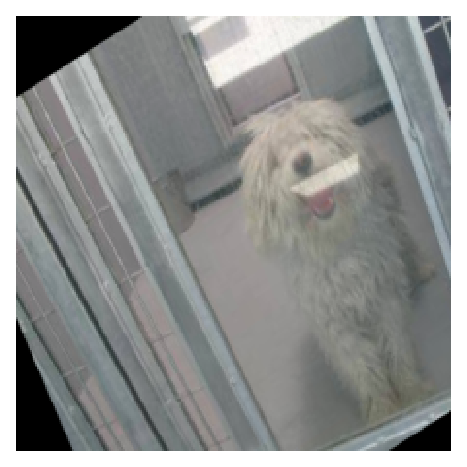

In [68]:
helper.imshow(inputs[2], normalize=True)

## pretrained models

That's a really deep model. I don't even try to print it here. The only thing we have to know - this model contains a classifier: `(classifier): Linear(in_features=1024, out_features=1000)`. We have to do 2 things:

- first freeze layers in the net;
- replace classifier;

In [69]:
model = models.densenet121(pretrained=True)

In [71]:
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))